In [3]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

## 相位噪声模拟  
时间分辨率1us，采样率1MHz，模拟时间1s  
用布朗运动模拟相位噪声

      phase speed     phase
Mean    -0.000002 -6.359112
Std      0.008713  2.486367
Var      0.000076  6.182020


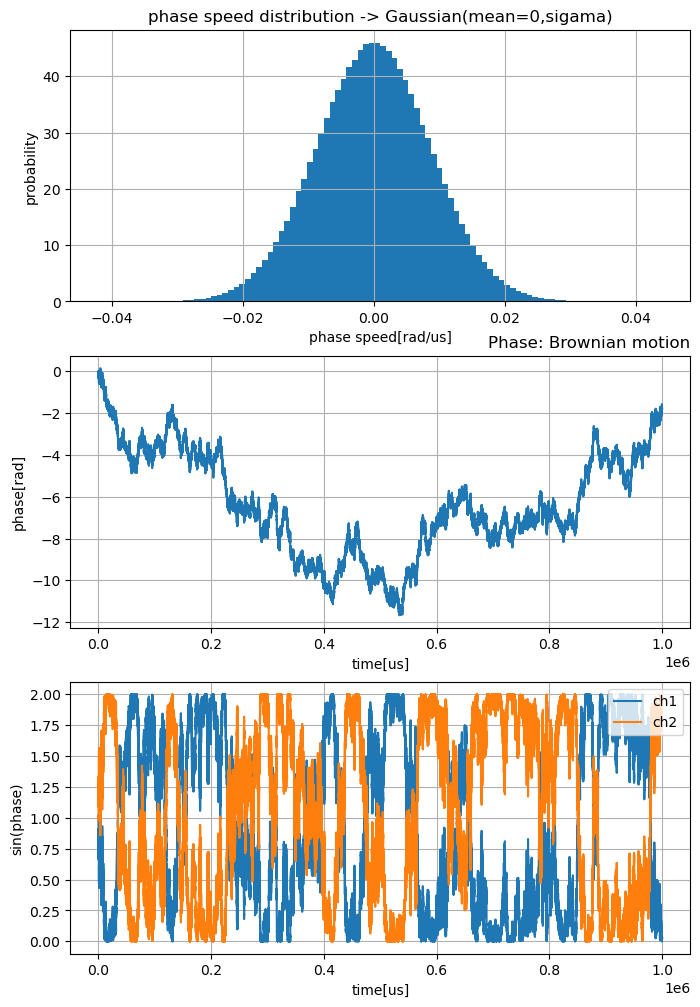

In [4]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.5/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

In [6]:
def fb_weight(measure, time_exposure):
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=3*phase_speed_in_measure #3 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure))
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    return measure_filtered


如果相位噪声满足独立随机分布，那么用var评估比较好，因为其关于时间（采样点）是线性的；

### method 1: 反馈1个sample  
每隔 time exposure 反馈一次  

In [30]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())
    

time_exposure=200 #us
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M1=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M1=np.zeros_like(phase_speed_M1)
phase_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量出的反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M1[i]=np.cumsum(phase_speed_M1[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M1[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M1[i],2)
    ###引入shot noise
    ch1_measure=measure_count(sig_ch1_exposure[i],2)#rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
    ch2_measure=measure_count(sig_ch2_exposure[i],2)#rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
    phase_measure_M1[i]=get_phase_from_count(ch1_measure,ch2_measure)
    #phase_measure_M1[i]=phase_M1[i,-1]
    
    ##---反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M1[i+1,0]-=phase_measure_M1[i]#fb_weight(phase_measure_M1[i],time_exposure) # 反馈到下一个exposure

    phase_offest=phase_M1[i,-1]
phase_out_M1=np.cumsum(phase_speed_M1.reshape(-1))
push_data(phase_out_M1,'phase M1')

100%|██████████| 5000/5000 [00:00<00:00, 13221.01it/s]

      phase speed     phase  phase M1  phase M1 without shot noise  \
Mean    -0.000002 -6.359112 -0.000586                    -0.000179   
Std      0.008713  2.486367  0.124656                     0.080283   
Var      0.000076  6.182020  0.015539                     0.006445   

      phase M1 best way  
Mean           0.000057  
Std            0.062855  
Var            0.003951  


#### M1 without shot noise

In [31]:
#time_exposure=20 #us
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M1=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M1=np.zeros_like(phase_speed_M1)
phase_measure_M1_wsn=np.zeros(phase_speed_M1.shape[0]) # 测量出的反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M1[i]=np.cumsum(phase_speed_M1[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M1[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M1[i],2)
    ###引入shot noise
    ch1_measure=measure_count(sig_ch1_exposure[i],1)#rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
    ch2_measure=measure_count(sig_ch2_exposure[i],1)#rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
    phase_measure_M1_wsn[i]=get_phase_from_count(ch1_measure,ch2_measure)
    
    ##---反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M1[i+1,0]-=phase_measure_M1_wsn[i] # 反馈到下一个exposure

    phase_offest=phase_M1[i,-1]
phase_out_M1_without_shot_noise=np.cumsum(phase_speed_M1.reshape(-1))
push_data(phase_out_M1_without_shot_noise,'phase M1 without shot noise')

100%|██████████| 5000/5000 [00:00<00:00, 22007.82it/s]

      phase speed     phase  phase M1  phase M1 without shot noise  \
Mean    -0.000002 -6.359112 -0.000586                    -0.000354   
Std      0.008713  2.486367  0.124656                     0.114067   
Var      0.000076  6.182020  0.015539                     0.013011   

      phase M1 best way  
Mean           0.000057  
Std            0.062855  
Var            0.003951  


#### M1 without shot noise and estimate best phase

In [32]:
##time_exposure=20 #us
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M1=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M1=np.zeros_like(phase_speed_M1)
phase_measure_M1_best=np.zeros(phase_speed_M1.shape[0]) # 测量出的反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M1[i]=np.cumsum(phase_speed_M1[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M1[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M1[i],2)
    ###引入shot noise
    ch1_measure=measure_count(sig_ch1_exposure[i],0)#rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
    ch2_measure=measure_count(sig_ch2_exposure[i],0)#rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
    phase_measure_M1_best[i]=get_phase_from_count(ch1_measure,ch2_measure)
    
    ##---反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M1[i+1,0]-=phase_measure_M1_best[i] # 反馈到下一个exposure

    phase_offest=phase_M1[i,-1]
phase_out_M1_best=np.cumsum(phase_speed_M1.reshape(-1))
push_data(phase_out_M1_best,'phase M1 best way')

100%|██████████| 5000/5000 [00:00<00:00, 22753.80it/s]

      phase speed     phase  phase M1  phase M1 without shot noise  \
Mean    -0.000002 -6.359112 -0.000586                    -0.000354   
Std      0.008713  2.486367  0.124656                     0.114067   
Var      0.000076  6.182020  0.015539                     0.013011   

      phase M1 best way  
Mean          -0.000038  
Std            0.089217  
Var            0.007960  


In [102]:
def simu_M1_with_Measure(time_exposure,measure_method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M1=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M1=np.zeros_like(phase_speed_M1)
    phase_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量出的反馈量
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M1[i]=np.cumsum(phase_speed_M1[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M1[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M1[i],2)
        ###引入shot noise
        ch1_measure=measure_count(sig_ch1_exposure[i],measure_method)#rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
        ch2_measure=measure_count(sig_ch2_exposure[i],measure_method)#rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
        phase_measure_M1[i]=get_phase_from_count(ch1_measure,ch2_measure)
        #c0=fb_weight(phase_measure_M1[i],time_exposure) 
        c0=phase_measure_M1[i]
        
        
        ##---反馈
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M1[i+1,0]-=c0 # 反馈到下一个exposure

        phase_offest=phase_M1[i,-1]
    phase_out_M1=np.cumsum(phase_speed_M1.reshape(-1))
    return phase_out_M1,phase_measure_M1

In [103]:
df=pd.DataFrame(columns=['time_exposure','phase_var','measure_var'])
time_test=[10,20,40,50,80,100,200,250,400,500,800]
time_d=[]
phase_var=[]
measure_var=[]
for time_exposure in time_test:
    for method in [0,1,2]:
        phase_out_M1,phase_measure_M1=simu_M1_with_Measure(time_exposure,method)
        time_d.append(time_exposure)
        phase_var.append(np.var(phase_out_M1))
        measure_var.append(np.var(phase_measure_M1))
df['time_exposure']=time_d
df['phase_var']=phase_var
df['measure_var']=measure_var

100%|██████████| 1250/1250 [00:00<00:00, 17219.18it/s]


Text(0, 0.5, 'Measure variance')

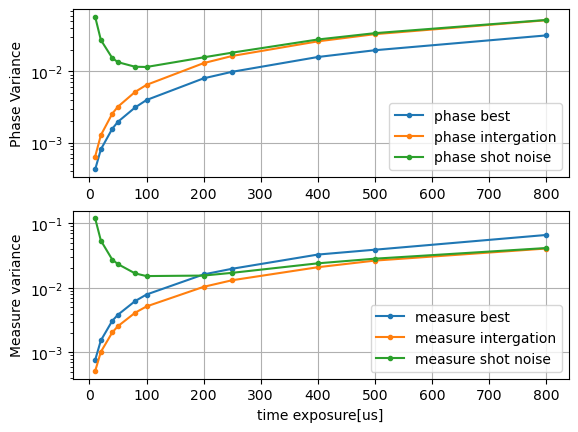

In [104]:
meas_meath=['best','intergation','shot noise']
plt.subplot(2,1,1)
for i in range(3):
    plt.plot(df['time_exposure'][i::3],df['phase_var'][i::3],'.-',label='phase {}'.format(meas_meath[i]))
plt.grid()
plt.legend()
plt.yscale('log')
plt.ylabel('Phase Variance')
plt.subplot(2,1,2)
for i in range(3):
    plt.plot(df['time_exposure'][i::3],df['measure_var'][i::3],'.-',label='measure {}'.format(meas_meath[i]))
    #plt.plot(df['time_exposure'],df['measure_var'],'.-',label='measure')
plt.yscale('log')
plt.grid()
plt.legend()
plt.xlabel('time exposure[us]')
plt.ylabel('Measure variance')

Text(0, 0.5, 'Phase Variance[rad$^2$]')

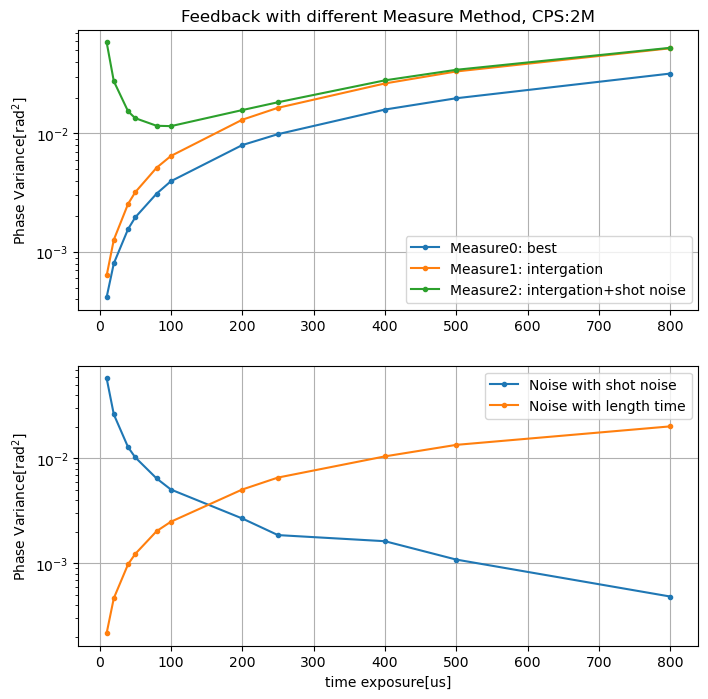

In [106]:
meas_meath=['best','intergation','intergation+shot noise']
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.title('Feedback with different Measure Method, CPS:{}M'.format(SIG_AMP*2))
for i in range(3):
    plt.plot(df['time_exposure'][i::3],df['phase_var'][i::3],'.-',label='Measure{}: {}'.format(i,meas_meath[i]))
plt.grid()
plt.legend()
plt.yscale('log')
plt.ylabel('Phase Variance[rad$^2$]')
plt.subplot(2,1,2)
delat_shot_noise=df['phase_var'][2::3].values-df['phase_var'][1::3].values
delat_len_time=df['phase_var'][1::3].values-df['phase_var'][0::3].values
plt.plot(df['time_exposure'][::3],delat_shot_noise,'.-',label='Noise with shot noise')
plt.plot(df['time_exposure'][::3],delat_len_time,'.-',label='Noise with length time')
plt.yscale('log')
plt.grid()
plt.legend()
plt.xlabel('time exposure[us]')
plt.ylabel('Phase Variance[rad$^2$]')

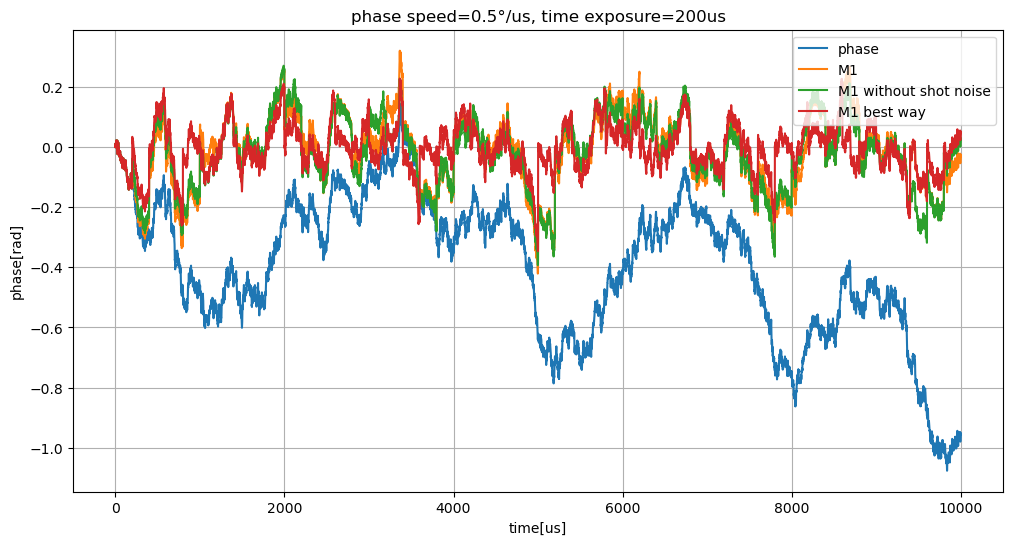

In [33]:
x0=0000
x1=10000
plt.figure(figsize=(12,6))
plt.plot(phase[x0:x1],label='phase')
plt.plot(phase_out_M1[x0:x1],label='M1')
plt.plot(phase_out_M1_without_shot_noise[x0:x1],label='M1 without shot noise')
plt.plot(phase_out_M1_best[x0:x1],label='M1 best way')
# plt.plot((np.arange(x1//time_exposure)+1)*time_exposure-1,phase_measure_M1[:x1//time_exposure],'x-',label='M1 measure')
# plt.plot((np.arange(x1//time_exposure)+1)*time_exposure-1,phase_measure_M1_wsn[:x1//time_exposure],'x-',label='M1 without noise measure')
# plt.plot((np.arange(x1//time_exposure)+1)*time_exposure-1,phase_measure_M1_best[:x1//time_exposure],'x-',label='M1 best measure')
plt.legend(loc=1)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('phase speed={}°/us, time exposure={}us'.format(PHASE_SEEPD/np.pi*180,time_exposure))
plt.grid()

(0.0, 1000.0)

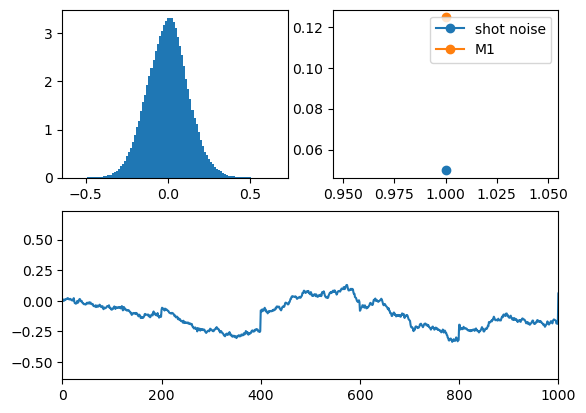

In [34]:
# 分别画出不同方法的相位和相位速度的分布
plt.figure()
ax1=plt.subplot(2,2,1)
ax1.hist(phase_out_M1,bins=100,density=True,label='M1')
ax2=plt.subplot(2,2,2)
ax2.plot(SIG_AMP,1/np.sqrt(SIG_AMP*time_exposure*2),'o-',label='shot noise')
ax2.plot(SIG_AMP,np.std(phase_out_M1),'o-',label='M1')
ax2.legend(loc=1)
ax3=plt.subplot(2,1,2)
ax3.plot(time_axis,phase_out_M1,label='M1')
ax3.set_xlim(0,1000)
